1.      Regresión (HISTORICO_SUERTES.xlsx): Predecir dos variables clave:

Toneladas de caña por hectárea (TCH): Indicador de la productividad de la tierra.
Porcentaje de sacarosa (%Sac.Caña): Medida de la calidad de la caña y la cantidad de azúcar extraíble.

In [1]:
# cargar librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
# crear pipeline para estandarizar las columnas numericas y codificar las categoricas
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [2]:
# Cargar archivo excel con la data y crear un dataframe
df_original = pd.read_excel('HISTORICO_SUERTES.xlsx')
print(df_original.shape)

(21027, 85)


In [3]:
# creamos una copia del dataframe original
df_copy = df_original.copy()
#imprimir dimensiones  
df_copy.shape

(21027, 85)

In [4]:
# Eliminar las filas donde el valor del campo <Destino 1=Semilla> sea igual a 1, esos cortes de caña no son relevantes
df_copy = df_copy[df_copy['Destino 1=Semilla'] != 1]

In [5]:
# Convertir de YYYYMM a MM la columna 'Período'
df_copy['Período'] = df_copy['Período'].astype(str).str[-2:]
# Cambiar el nombre de la columna 'Período' a 'Mes'
df_copy = df_copy.rename(columns={'Período': 'Mes'})

In [6]:
# Cantidad de nulos de la columna 'Mes'
print(df_copy['Mes'].isnull().sum())
# Imprimir Tipo de dato de la columna 'Mes'
print(df_copy['Mes'].dtype)
# Imprimir cantidad de datos únicos y sus frecuencias en la columna 'Mes'
print(df_copy['Mes'].value_counts())
print("Cantidad de valores únicos:", df_copy['Mes'].nunique())

0
object
Mes
01    2061
03    1992
04    1902
10    1835
08    1833
06    1822
09    1818
12    1766
07    1620
05    1422
11    1343
02    1319
Name: count, dtype: int64
Cantidad de valores únicos: 12


In [7]:
# creamos una nueva columna llamada Edad con el resultado de la diferencia de estas dos columnas <F.Ult.Corte> y <F.Siembra>
df_copy['Edad'] = (df_copy['F.Ult.Corte'] - df_copy['F.Siembra']).dt.days


tener en cuenta tambien la aplicacion del madurante, los meses podrian ser importantes ya que hay unos mas lluviosos que otros, las lluvias, radiacion solar, vejez, 

In [8]:
# Se utilizaran estas columnas numericas para el preprocesamiento, se obtiene luego de validar datos en el notebook Desarrollo_TallerFinal_2
columnas_numericas = ['Area Neta', 'TonUltCorte', 'TCH',  '%Sac.Caña',  '%Fibra Caña', '%AR Jugo', '%ME Tot', 'Brix', 'Pureza', 'Vejez', 'Num.Riegos', 'M3 Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3', 'Lluvias tres a seis', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Edad']
# Se utilizaran estas columnas categoricas para el preprocesamiento, se obtiene luego de validar datos en el notebook Desarrollo_TallerFinal_2
columnas_categoricas = ['Variedad','Producto','Cultivo','Tipo Quema','T.Corte','Mes']

In [9]:
# Crear nuevo dataframe con las columnas seleccionadas columnas_numericas y columnas_categoricas
df_procesado = df_copy[columnas_numericas + columnas_categoricas].copy()
# imprimir dimensiones
df_procesado.shape    

(20733, 26)

In [10]:
# Mostrar de forma aleatoria 20 registros del dataframe
df_procesado.sample(20)


,Area Neta,TonUltCorte,TCH,%Sac.Caña,%Fibra Caña,%AR Jugo,%ME Tot,Brix,Pureza,Vejez,...,Lluvias seis a nueve,Luvias 9 -FC,%Infest.Diatrea,Edad,Variedad,Producto,Cultivo,Tipo Quema,T.Corte,Mes
6790,3.07,455.070,148.231270,10.6300,13.2550,0.9500,11.8690,13.1381,80.3034,4.635,...,0.0,0.00,NaN,753,RB73-2223,NaN,Normal,VERDE,MECANIZADO,07
8811,9.19,1445.340,157.273122,12.8565,13.5953,0.7915,8.4295,14.8052,86.6770,2.286,...,0.0,0.00,NaN,1735,CC01-1940,BONUS 250 EC REGULADOR FISIOLÓGICO,Normal,VERDE,MECANIZADO,03
5565,6.39,657.730,102.931142,13.7373,13.8247,0.4640,3.6521,15.6624,86.6525,30.680,...,107.0,434.00,3.2372,1941,CC01-1940,BONUS 250 EC REGULADOR FISIOLÓGICO,Normal,Q.PROGRAMADA,MANUAL,01
17195,9.23,1111.270,120.397616,12.9727,18.1718,0.5557,8.6294,14.8448,87.5126,2.123,...,0.0,0.00,NaN,5454,CC85-92,BONUS 250 EC REGULADOR FISIOLOGICO,Normal,VERDE,MECANIZADO,03
2195,13.55,1893.550,139.745387,11.4715,14.9334,0.4629,11.4431,13.6520,84.1406,2.207,...,0.0,0.00,NaN,5776,PR61-632,BONUS 250 EC REGULADOR FISIOLÓGICO,Normal,VERDE,MECANIZADO,11
10300,4.52,463.780,102.606194,12.6003,15.6654,1.1747,10.3283,14.8151,85.4465,22.003,...,107.0,74.00,3.4246,2815,CC85-92,BONUS 250 EC REGULADOR FISIOLÓGICO,Normal,VERDE,MECANIZADO,09
20556,2.05,329.445,160.704878,11.5993,14.8710,0.7450,9.8250,13.7712,83.9886,8.704,...,0.0,43.00,NaN,2173,CC01-1940,BONUS 250 EC REGULADOR FISIOLOGICO,Normal,VERDE,MECANIZADO,04
15062,17.00,2484.225,146.130882,10.0354,14.5374,1.0171,10.5665,12.3950,80.5842,2.017,...,630.0,1236.00,2.4613,458,CC05-430,NaN,Organico,VERDE,MECANIZADO,07
3443,6.15,1063.230,172.882926,12.9827,16.3636,0.3973,7.3099,15.2092,84.6782,2.691,...,115.0,602.00,3.1587,503,CC01-1940,BONUS 250 EC REGULADOR FISIOLÓGICO,Normal,VERDE,MECANIZADO,04
13873,1.75,170.860,97.634285,13.4700,15.7540,0.8000,8.4450,15.4360,87.2635,2.413,...,62.0,199.00,NaN,2051,CC01-1940,NaN,Normal,VERDE,MECANIZADO,01


In [11]:
# Imprimir informacion del nuevo dataframe
print(df_procesado.info())
# Imprimir total nulos por columna
print(df_procesado.isnull().sum())  

<class 'pandas.core.frame.DataFrame'>
Index: 20733 entries, 0 to 21026
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Area Neta               20733 non-null  float64
 1   TonUltCorte             20733 non-null  float64
 2   TCH                     20733 non-null  float64
 3   %Sac.Caña               20577 non-null  float64
 4   %Fibra Caña             18988 non-null  float64
 5   %AR Jugo                18903 non-null  float64
 6   %ME Tot                 19306 non-null  float64
 7   Brix                    20578 non-null  float64
 8   Pureza                  20576 non-null  float64
 9   Vejez                   18485 non-null  float64
 10  Num.Riegos              8178 non-null   float64
 11  M3 Riego                20733 non-null  float64
 12  Lluvias (2 Meses Ant.)  20733 non-null  float64
 13  Lluvias Ciclo           20733 non-null  float64
 14  Lluvias 0 -3            20733 non-null  flo

* se parte del supuesto de que si no se indican numero de riegos es debido a que no se ejecutaron riegos al cultivo de caña
* Se parte del supuesto de que si no se indica porcentaje de infestacion es debido a que el cultivo esta limpio 
* Se parte del supuesto de que si no se indica producto es que no se utilizaron productos para la maduracion 


In [12]:
# Cambiar nulos por el valor 0 en la columna 'Num.Riegos'
df_procesado['Num.Riegos'] = df_procesado['Num.Riegos'].fillna(0)
# Cambiar nulos por el valor 0 en la columna '%Infesta.Diatrea'
df_procesado['%Infest.Diatrea'] = df_procesado['%Infest.Diatrea'].fillna(0) 
# Cambiar nulos por valor 0 en la columna 'Producto'
df_procesado['Producto']= df_procesado['Producto'].fillna(0) 
# Cambiar todos los datos diferentes de 0 en la columna 'Producto' por 1
df_procesado['Producto'] = np.where(df_procesado['Producto'] != 0, 1, 0)

In [13]:
# Imprimir shape del dataframe procesado
print(df_procesado.shape)
print('-------------------  ------------------- -------------------')
# Se imprimen nulos del dataframe df_procesado
print(df_procesado.isnull().sum())





(20733, 26)
-------------------  ------------------- -------------------
Area Neta                    0
TonUltCorte                  0
TCH                          0
%Sac.Caña                  156
%Fibra Caña               1745
%AR Jugo                  1830
%ME Tot                   1427
Brix                       155
Pureza                     157
Vejez                     2248
Num.Riegos                   0
M3 Riego                     0
Lluvias (2 Meses Ant.)       0
Lluvias Ciclo                0
Lluvias 0 -3                 0
Lluvias tres a seis          0
Lluvias seis a nueve         0
Luvias 9 -FC                 0
%Infest.Diatrea              0
Edad                         0
Variedad                     0
Producto                     0
Cultivo                      2
Tipo Quema                   0
T.Corte                      0
Mes                          0
dtype: int64


* Se ejecuta estandarizacion de los datos, se eliminan nulos y se aplica escalas

In [14]:
# Pipeline para estandarizar columnas numéricas y codificar columnas categóricas
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline para columnas numéricas: imputación + escalado robusto
pipeline_numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Pipeline para columnas categóricas: imputación + codificación one-hot
pipeline_categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer para aplicar ambos pipelines
preprocesador = ColumnTransformer([
    ('num', pipeline_numerico, columnas_numericas),
    ('cat', pipeline_categorico, columnas_categoricas)
], remainder='passthrough')

# Aplicar el pipeline al dataframe
matriz_estandarizada = preprocesador.fit_transform(df_procesado)

# Si se desea reconstruir el DataFrame con nombres de columnas:
columnas_transformadas = preprocesador.get_feature_names_out()

# Si la matriz está en formato sparse, convertirla a densa
if hasattr(matriz_estandarizada, "toarray"):
    matriz_estandarizada = matriz_estandarizada.toarray()

# Crear el DataFrame con la matriz transformada
df_estandarizado = pd.DataFrame(
    matriz_estandarizada,
    columns=columnas_transformadas,
    index=df_procesado.index
)

# Mostrar las dimensiones y las primeras filas
print("Forma del DataFrame estandarizado:", df_estandarizado.shape)
print("\nPrimeras filas del DataFrame estandarizado:")
print(df_estandarizado.head())

Forma del DataFrame estandarizado: (20733, 100)

Primeras filas del DataFrame estandarizado:
   num__Area Neta  num__TonUltCorte  num__TCH  num__%Sac.Caña  \
0       -0.123429         -0.128060 -0.208437        0.952299   
1       -0.643429         -0.621883 -0.871021        0.324159   
2        0.132571          0.464529  1.076554       -0.298078   
3       -0.689143         -0.615510  0.168538       -0.750652   
4       -0.291429         -0.307642 -0.404996       -1.478861   

   num__%Fibra Caña  num__%AR Jugo  num__%ME Tot  num__Brix  num__Pureza  \
0          0.864328       0.534964      0.803321   0.928241     0.501018   
1          0.878557      -0.573175      0.385270   0.587915    -0.356617   
2          0.099223      -0.343905      1.556833  -0.135863    -0.328916   
3          1.253448      -0.114635     -0.740315  -0.447264    -0.851930   
4         -0.535628       0.955292     -2.186037  -0.876580    -2.042689   

   num__Vejez  ...  cat__Mes_03  cat__Mes_04  cat__Mes_05  

In [15]:
# Encontrar valores atípicos en las columnas numéricas de un DataFrame usando el método IQR

def encontrar_atipicos(df, columnas=None):
    if columnas is None:
        columnas = df.select_dtypes(include=np.number).columns
    atipicos = {}
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)][col]
        atipicos[col] = outliers
        print(f'Columna: {col} - Cantidad de atípicos: {outliers.count()}')
    return atipicos

# Ejemplo de uso:
atipicos = encontrar_atipicos(df_estandarizado)

Columna: num__Area Neta - Cantidad de atípicos: 602
Columna: num__TonUltCorte - Cantidad de atípicos: 801
Columna: num__TCH - Cantidad de atípicos: 296
Columna: num__%Sac.Caña - Cantidad de atípicos: 324
Columna: num__%Fibra Caña - Cantidad de atípicos: 784
Columna: num__%AR Jugo - Cantidad de atípicos: 710
Columna: num__%ME Tot - Cantidad de atípicos: 1576
Columna: num__Brix - Cantidad de atípicos: 1791
Columna: num__Pureza - Cantidad de atípicos: 1963
Columna: num__Vejez - Cantidad de atípicos: 4334
Columna: num__Num.Riegos - Cantidad de atípicos: 761
Columna: num__M3 Riego - Cantidad de atípicos: 2964
Columna: num__Lluvias (2 Meses Ant.) - Cantidad de atípicos: 413
Columna: num__Lluvias Ciclo - Cantidad de atípicos: 104
Columna: num__Lluvias 0 -3 - Cantidad de atípicos: 178
Columna: num__Lluvias tres a seis - Cantidad de atípicos: 236
Columna: num__Lluvias seis a nueve - Cantidad de atípicos: 203
Columna: num__Luvias 9 -FC - Cantidad de atípicos: 898
Columna: num__%Infest.Diatrea - 

In [16]:
# Imprimir Cantidad de nulos en el dataframe estandarizado
print(df_estandarizado.isnull().sum())  

num__Area Neta      0
num__TonUltCorte    0
num__TCH            0
num__%Sac.Caña      0
num__%Fibra Caña    0
                   ..
cat__Mes_08         0
cat__Mes_09         0
cat__Mes_10         0
cat__Mes_11         0
cat__Mes_12         0
Length: 100, dtype: int64


In [17]:
# Ajustar pandas para mostrar más filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [18]:
# Generar matriz de correlacion y visualizar solo las correlaciones con la variables TCH
correlation_matrix = df_estandarizado.corr()
tch_correlation = correlation_matrix['num__TCH'].sort_values(ascending=False)
print(tch_correlation)  

num__TCH                        1.000000
num__TonUltCorte                0.315920
cat__Variedad_CC05-430          0.161746
num__Luvias 9 -FC               0.152464
cat__Variedad_CC01-1940         0.144041
num__%Infest.Diatrea            0.100962
num__Lluvias Ciclo              0.090074
num__M3 Riego                   0.088655
cat__Tipo Quema_VERDE           0.088232
num__Area Neta                  0.087125
num__Lluvias seis a nueve       0.071223
num__Lluvias (2 Meses Ant.)     0.065154
cat__T.Corte_MECANIZADO         0.064842
cat__Variedad_CC09-066          0.063516
cat__T.Corte_NO DEF.            0.056952
cat__Mes_07                     0.046057
cat__Producto_0                 0.040792
num__Lluvias tres a seis        0.032324
cat__Tipo Quema_NO DEF.         0.028323
cat__Variedad_CO421             0.022796
cat__Mes_09                     0.022267
cat__Variedad_CC01-1228         0.020685
cat__Cultivo_Organico           0.018127
cat__Variedad_CC01-1236         0.014556
cat__Mes_10     

In [19]:
# Generar matriz de correlacion y visualizar solo las correlaciones con la variables TCH
correlation_matrix = df_estandarizado.corr()
tch_correlation = correlation_matrix['num__Area Neta'].sort_values(ascending=False)
print(tch_correlation)  

num__Area Neta                  1.000000
num__TonUltCorte                0.948861
num__M3 Riego                   0.329199
num__%Infest.Diatrea            0.271006
cat__T.Corte_MECANIZADO         0.243134
cat__Producto_1                 0.167398
cat__Tipo Quema_VERDE           0.124196
num__%Sac.Caña                  0.112636
num__Brix                       0.089418
num__Pureza                     0.088076
num__TCH                        0.087125
cat__Variedad_CC01-1940         0.079296
cat__Cultivo_Organico           0.039485
cat__Mes_09                     0.033325
cat__Variedad_CC85-92           0.030632
cat__Variedad_CC82-15           0.023102
num__Edad                       0.022917
num__%ME Tot                    0.021648
cat__Mes_06                     0.018085
cat__Variedad_CC93-4418         0.017035
cat__Mes_03                     0.015578
cat__Mes_12                     0.014326
cat__Variedad_CC05-230          0.013924
cat__Variedad_CC01-1228         0.013835
num__Num.Riegos 

In [20]:
# Generar matriz de correlación y visualizar solo las correlaciones con la variable num__%Sac.Caña
correlation_matrix = df_estandarizado.corr()
tch_correlation = correlation_matrix['num__TonUltCorte'].sort_values(ascending=False)
print(tch_correlation)  

num__TonUltCorte                1.000000
num__Area Neta                  0.948861
num__M3 Riego                   0.338326
num__TCH                        0.315920
num__%Infest.Diatrea            0.283715
cat__T.Corte_MECANIZADO         0.236877
cat__Producto_1                 0.140299
cat__Tipo Quema_VERDE           0.132746
cat__Variedad_CC01-1940         0.117737
num__Pureza                     0.067466
num__Brix                       0.057886
num__%Sac.Caña                  0.049304
cat__Cultivo_Organico           0.046035
cat__Variedad_CC05-430          0.037641
cat__Mes_09                     0.033516
num__%ME Tot                    0.025113
cat__Mes_06                     0.023047
cat__Variedad_CC82-15           0.022255
cat__Variedad_CC01-1228         0.017967
cat__Mes_12                     0.015177
cat__Variedad_CC09-066          0.011435
cat__Variedad_CC05-230          0.010293
cat__Mes_10                     0.008113
num__Num.Riegos                 0.007025
cat__Mes_03     

In [21]:
# para pruebas , ya que existe alta correlacion entre area neta y toneladas ultimo corte
# Eliminar la columna 'num__Area Neta' del dataframe
#df_estandarizado = df_estandarizado.drop(columns=['num__Area Neta'])

In [22]:
# Crear nuevo dataframe llamdo df_final_SC 
df_final_SC = df_estandarizado.copy()
# Eliminar columna 'num__TCH' de un DataFrame
df_final_SC = df_final_SC.drop(columns=['num__TCH'])
print(df_final_SC.shape)
print(df_final_SC.info())   

(20733, 99)
<class 'pandas.core.frame.DataFrame'>
Index: 20733 entries, 0 to 21026
Data columns (total 99 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   num__Area Neta                20733 non-null  float64
 1   num__TonUltCorte              20733 non-null  float64
 2   num__%Sac.Caña                20733 non-null  float64
 3   num__%Fibra Caña              20733 non-null  float64
 4   num__%AR Jugo                 20733 non-null  float64
 5   num__%ME Tot                  20733 non-null  float64
 6   num__Brix                     20733 non-null  float64
 7   num__Pureza                   20733 non-null  float64
 8   num__Vejez                    20733 non-null  float64
 9   num__Num.Riegos               20733 non-null  float64
 10  num__M3 Riego                 20733 non-null  float64
 11  num__Lluvias (2 Meses Ant.)   20733 non-null  float64
 12  num__Lluvias Ciclo            20733 non-null  float64

* Se eliminara la columna num__TAH porque tiene alta relacion con la variable objetivo num__TCH

In [23]:
# Se eliminara la columna num__TAH porque tiene alta relacion con la variable objetivo num__TCH
df_final = df_estandarizado.copy()
# se elimina la columna num__%Sac.Caña
df_final = df_final.drop(columns=['num__%Sac.Caña'])
print(df_final.shape)

(20733, 99)


* Codigo para TCH

In [24]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Buscar el mejor valor de alpha para Lasso
alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
resultados_lasso = []

X = df_final.drop(columns=['num__TCH'])
y = df_final['num__TCH']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for alpha in alphas:
    modelo = Lasso(alpha=alpha, random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    resultados_lasso.append({
        'alpha': alpha,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })

import pandas as pd
df_lasso = pd.DataFrame(resultados_lasso)
print("Resultados Lasso:")
print(df_lasso.sort_values(by='R2', ascending=False))

# Buscar el mejor valor de k para KNN
from sklearn.neighbors import KNeighborsRegressor
resultados_knn = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    resultados_knn.append({
        'k': k,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })

df_knn = pd.DataFrame(resultados_knn)
print("Resultados KNN:")
print(df_knn.sort_values(by='R2', ascending=False))

Resultados Lasso:
    alpha        R2       MAE
0   0.001  0.599808  0.341777
1   0.010  0.578697  0.349538
2   0.100  0.125424  0.567746
3   0.500 -0.001198  0.613768
4   1.000 -0.001198  0.613768
5   5.000 -0.001198  0.613768
6  10.000 -0.001198  0.613768
Resultados KNN:
     k        R2       MAE
18  19  0.279471  0.507878
19  20  0.278759  0.507998
10  11  0.277928  0.507032
17  18  0.277707  0.508737
15  16  0.276791  0.508777
11  12  0.276391  0.508531
16  17  0.275863  0.509460
9   10  0.275521  0.508111
14  15  0.275267  0.509140
12  13  0.274254  0.509319
8    9  0.273330  0.507154
13  14  0.272248  0.509918
7    8  0.263273  0.510287
6    7  0.257418  0.512214
5    6  0.247193  0.515038
4    5  0.230728  0.520072
3    4  0.203936  0.529933
2    3  0.169404  0.539728
1    2  0.071143  0.565839
0    1 -0.179405  0.634004


In [25]:
# Caso para Sacarosa Caña 
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Buscar el mejor valor de alpha para Lasso
alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
resultados_lasso_SC = []

# Eliminar columna num__TCH 


X_SC = df_final_SC.drop(columns=['num__%Sac.Caña'])
y_SC = df_final_SC['num__%Sac.Caña']

from sklearn.model_selection import train_test_split
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X_SC, y_SC, test_size=0.2, random_state=42)

for alpha in alphas:
    modelo = Lasso(alpha=alpha, random_state=42)
    modelo.fit(X_train_SC, y_train_SC)
    y_pred = modelo.predict(X_test_SC)
    resultados_lasso_SC.append({
        'alpha': alpha,
        'R2': r2_score(y_test_SC, y_pred),
        'MAE': mean_absolute_error(y_test_SC, y_pred),
    })

import pandas as pd
df_lasso_SC = pd.DataFrame(resultados_lasso_SC)
print("Resultados Lasso Sacarosa Caña:")    
print(df_lasso_SC.sort_values(by='R2', ascending=False))

Resultados Lasso Sacarosa Caña:
    alpha        R2       MAE
0   0.001  0.731142  0.277176
1   0.010  0.705008  0.295065
2   0.100  0.557043  0.383538
3   0.500  0.020017  0.598848
4   1.000 -0.000085  0.605495
5   5.000 -0.000085  0.605495
6  10.000 -0.000085  0.605495


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Crear pipeline para Lasso con alpha=0.001
pipeline_lasso = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('regressor', Lasso(alpha=0.001, random_state=42))
])

# Ajustar el pipeline
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)

print("Lasso Pipeline (alpha=0.001):")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")

Lasso Pipeline (alpha=0.001):
R2: 0.5998
MAE: 0.3418


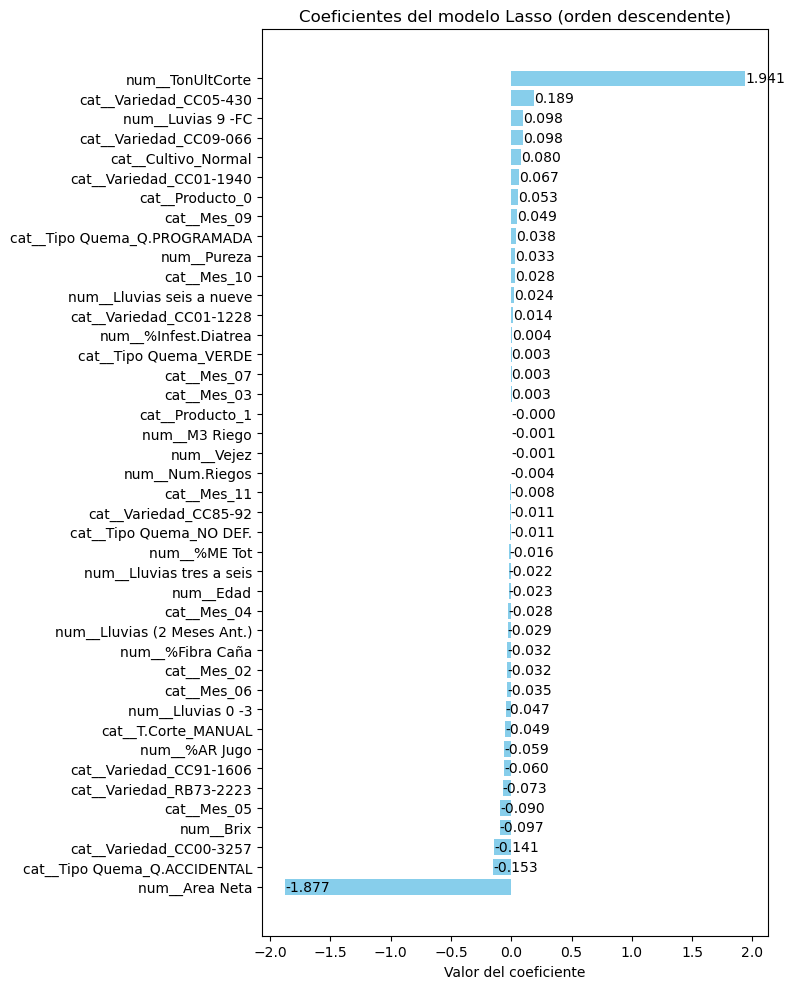

In [27]:
# Graficar los coeficientes del modelo Lasso en orden descendente y mostrar etiquetas y valores

import matplotlib.pyplot as plt
import numpy as np

# Obtener coeficientes y nombres de variables
coeficientes = pipeline_lasso.named_steps['regressor'].coef_
nombres = X.columns

# Filtrar coeficientes diferentes de 0
indices_no_cero = coeficientes != 0
coef_no_cero = coeficientes[indices_no_cero]
nombres_no_cero = nombres[indices_no_cero]

# Ordenar de mayor a menor
orden = np.argsort(coef_no_cero)[::-1]
coef_ordenados = coef_no_cero[orden]
nombres_ordenados = nombres_no_cero[orden]

plt.figure(figsize=(8, 10))
barras = plt.barh(nombres_ordenados, coef_ordenados, color='skyblue')
plt.xlabel("Valor del coeficiente")
plt.title("Coeficientes del modelo Lasso (orden descendente)")

# Añadir los valores numéricos en las barras
for barra, valor in zip(barras, coef_ordenados):
    plt.text(barra.get_width(), barra.get_y() + barra.get_height()/2, f'{valor:.3f}', va='center')

plt.gca().invert_yaxis()  # Para que el mayor quede arriba
plt.tight_layout()
plt.show()

In [33]:
# Utilizar el método Ridge en un pipeline para el análisis
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error

# Crear pipeline para Ridge con alpha=1.0 (puedes ajustar este valor)
pipeline_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

# Ajustar el pipeline
pipeline_ridge.fit(X_train, y_train)
y_pred_ridge = pipeline_ridge.predict(X_test)

# Calcular métricas
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("Ridge Pipeline (alpha=1.0):")
print(f"R2: {r2_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")

Ridge Pipeline (alpha=1.0):
R2: 0.6025
MAE: 0.3423


In [34]:
# Validación cruzada para el método Ridge
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

modelo_ridge = Ridge(alpha=1.0, random_state=42)
scores_ridge = cross_val_score(modelo_ridge, X, y, cv=5, scoring='r2')

print("R2 por fold:", scores_ridge)
print("R2 promedio CV:", scores_ridge.mean())
print("R2 std CV:", scores_ridge.std())

R2 por fold: [0.47809709 0.55862306 0.57997471 0.55139419 0.50865167]
R2 promedio CV: 0.5353481438861812
R2 std CV: 0.03682692638608428


In [28]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Crear el modelo Lasso con el mejor alpha encontrado
modelo_lasso = Lasso(alpha=0.001, random_state=42)

# Validación cruzada con 5 folds y métrica R2
scores = cross_val_score(modelo_lasso, X, y, cv=5, scoring='r2')

print("R2 por fold:", scores)
print("R2 promedio CV:", scores.mean())
print("R2 std CV:", scores.std())

R2 por fold: [0.50714912 0.55621346 0.57479878 0.55034321 0.5067818 ]
R2 promedio CV: 0.5390572754347835
R2 std CV: 0.027418967188085917


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo
rf = RandomForestRegressor(random_state=42).queNOejecutes # se marca para que no ejecute ya que toma al rededor de una hora en ejecutarse

# Definir el grid de parámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar la búsqueda de grilla con validación cruzada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Ejecutar la búsqueda
grid_search.fit(X, y)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score R2:", grid_search.best_score_)

AttributeError: 'RandomForestRegressor' object has no attribute 'queNOejecutes'

Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Mejor score R2: 0.9695871237114282

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Crear el modelo Random Forest con n_estimators=300 (puedes ajustar este valor)
modelo_rf = RandomForestRegressor(n_estimators=300,max_depth=None, min_samples_leaf=2,min_samples_split=2,random_state=42)

# Validación cruzada con 5 folds y métrica R2
scores_rf = cross_val_score(modelo_rf, X, y, cv=5, scoring='r2')

print("R2 por fold:", scores_rf)
print("R2 promedio CV:", scores_rf.mean())
print("R2 std CV:", scores_rf.std())

R2 por fold: [0.97374874 0.98371132 0.9695579  0.96144016 0.97320569]
R2 promedio CV: 0.9723327621432999
R2 std CV: 0.007191481695809025


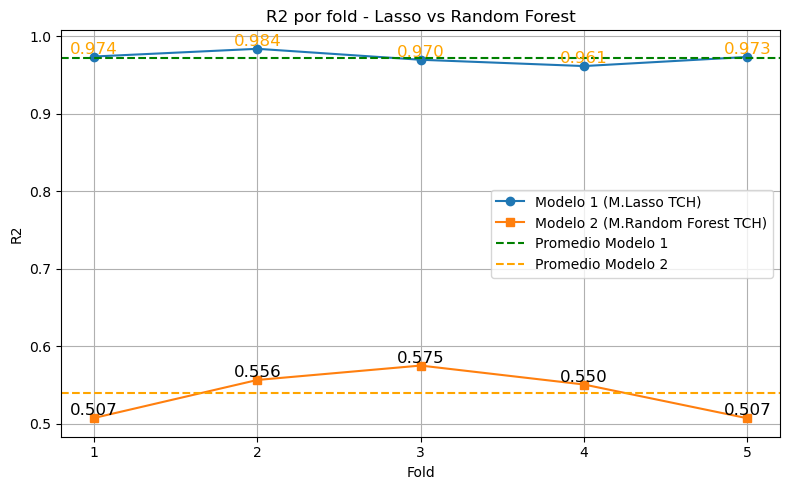

In [ ]:
# Graficar las métricas R2 por fold para dos modelos Random Forest

import matplotlib.pyplot as plt
import numpy as np

# Resultados de los dos modelos
r2_folds_modelo1 = [0.97374874, 0.98371132, 0.9695579, 0.96144016, 0.97320569]
r2_folds_modelo2 = [0.50714912, 0.55621346, 0.57479878, 0.55034321, 0.5067818]

folds = np.arange(1, 6)

plt.figure(figsize=(8, 5))
plt.plot(folds, r2_folds_modelo1, marker='o', label='Modelo 1 (M.Lasso TCH)')
plt.plot(folds, r2_folds_modelo2, marker='s', label='Modelo 2 (M.Random Forest TCH)')
plt.axhline(np.mean(r2_folds_modelo1), color='green', linestyle='--', label='Promedio Modelo 1')
plt.axhline(np.mean(r2_folds_modelo2), color='orange', linestyle='--', label='Promedio Modelo 2')

# Imprimir el valor de cada fold en la gráfica
for x, y in zip(folds, r2_folds_modelo1):
    plt.text(x, y, f'{y:.3f}', color='orange', fontsize=12, ha='center', va='bottom')
for x, y in zip(folds, r2_folds_modelo2):
    plt.text(x, y, f'{y:.3f}', color='black', fontsize=12, ha='center', va='bottom')


plt.title('R2 por fold - Lasso vs Random Forest')
plt.xlabel('Fold')
plt.ylabel('R2')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Resultado de RandomForestRefressor

    R2 por fold: [0.97165808 0.9804887  0.96592725 0.9606958  0.96916579]

    R2 promedio CV: 0.9695871237114282

    R2 std CV: 0.006569035553010742

A pesar de la alta colinealidad entre las variables "área neta" y "toneladas último corte", se optó por mantener ambas en el modelo predictivo. Esto se debe a que su combinación mejora la capacidad de predicción, y la eliminación de una de ellas reduce el rendimiento del modelo en aproximadamente un 50%. Tras evaluar varios modelos de regresión regularizada (Lasso, Ridge y Elastic Net), se determinó que **Lasso es el modelo óptimo** para este caso de uso, ya que mostró los resultados más estables en las pruebas de validación cruzada (k-fold).

Adicionalmente, se probó el modelo **Random Forest Regressor**, que superó significativamente al modelo Lasso. Este modelo elevó la capacidad de explicación de los casos del 53% a casi un 97%, demostrando su **superioridad para este problema de predicción**. 
